In [30]:
import numpy as np
from src.Preprocessing import create_labels_single_column
from src.Particle import ParticleType
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_predict

In [31]:
# loading the data
efps_top = np.load("../../Data/t_jets_efp_d5.npy")
efps_gluon = np.load("../../Data/g_jets_efp_d5.npy")
efps_quark = np.load("../../Data/q_jets_efp_d5.npy")

print(f"Number of Top Jets: {efps_top.shape[0]}")
print(f"Number of Gluon Jets: {efps_gluon.shape[0]}")
print(f"Number of LightQuark Jets: {efps_quark.shape[0]}")

Number of Top Jets: 177945
Number of Gluon Jets: 177252
Number of LightQuark Jets: 170679


In [32]:
# joinning the data 
# half of the data represents Top jets, the other half represents non-top quark jets
X = np.vstack((efps_top, efps_gluon[: int(efps_gluon.shape[0]/2)], efps_quark[: int(efps_quark.shape[0]/2)]))
y = create_labels_single_column(jet_inputs={ParticleType.Gluon: (efps_top.shape[0], X.shape[0] - 1), ParticleType.Top: (0, efps_top.shape[0] - 1)})
# shuffling the data
X, y = shuffle(X, y, random_state=42)

In [33]:
# Let us use the StandardScaler to leave each feature with the same order of magniture
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [34]:
# Dividing the data into trainning, validation, and test
# diving the set into trainning, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print(f"Size of the Training set: {X_train.shape[0]}")
print(f"Size of the Validation set: {X_val.shape[0]}")
print(f"Size of the Test set: {X_test.shape[0]}")

Size of the Training set: 254254
Size of the Validation set: 44869
Size of the Test set: 52787


In [35]:
# defining the model
# d <= 5
# l2, C = 0.04, solver = lbfgs
# l1, C = 0.0005, solver = saga
# d <= 7
# l2, C = 0.01, solver = lbfgs
log_reg = LogisticRegression(penalty='l2', C=0.04, solver='lbfgs', max_iter=500)
log_reg.fit(X_train, y_train)

coefs = ', '.join([f'{val:.2f}' for val in log_reg.coef_[0]])
print(f"Coefficients:", coefs)
print(f"Intercept {log_reg.intercept_[0]:.3f}")

Coefficients: 4.48, 5.25, -0.49, -0.98, 0.53, -1.49, -0.44, -0.63, 0.37, 0.02, 0.34, -3.06, 2.86, 0.13, 2.49, -1.63, -0.24, -0.16, 0.16, -1.63, 0.64, 0.21, -0.12, -0.12, 0.21, 0.56, 1.12, 0.80, 0.45, 0.18, -1.49, -1.72, -2.75, -0.39, 0.07, 0.15, -0.06, -0.08, 0.30, 0.14, -0.30, -0.42, 0.09, -0.71, -1.13, -1.65, 0.77, 0.15, -0.11, -0.43, -0.78, -0.41, -0.39, -2.39, 0.33, -0.21, 0.91, -0.31, 0.30, -1.20, 0.86, 0.32, 1.12, -0.01, 0.03, 1.14, -0.10, 0.34, 0.16, -1.08, 0.23, 0.40, 0.54, 0.81, 0.08, -0.02, -0.33, -0.34, -1.37, 0.41, 0.02, 0.06, 0.22, 0.10, 0.00, 0.79, 0.10, -0.30, -0.06, 0.06, -0.02, 0.32, 0.17, 0.61, 0.73, 0.47, -0.12, 0.38, -0.05, 0.20, -0.15
Intercept -0.047


In [36]:
print("Non-vanishing coefficients indices:")
best_efps = np.where(abs(log_reg.coef_[0]) > 1)[0]
print(best_efps)

Non-vanishing coefficients indices:
[ 0  1  5 11 12 14 15 19 26 30 31 32 44 45 53 59 62 65 69 78]


In [37]:
# Tranning set
y_train_predict = log_reg.predict(X_train)

print("Trainnig set:")
print(f"Recall for Top tagging: {recall_score(y_train, y_train_predict):.2f}")
print(f"Precision for Top tagging: {precision_score(y_train, y_train_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_train, y_train_predict, labels=[0, 1]))

Trainnig set:
Recall for Top tagging: 0.89
Precision for Top tagging: 0.85
Confusion Matrix
[[105035  20498]
 [ 14312 114409]]


In [38]:
y_val_predict = log_reg.predict(X_val)

print("Validation set:")
print(f"Recall for Top tagging: {recall_score(y_val, y_val_predict):.2f}")
print(f"Precision for Top tagging: {precision_score(y_val, y_val_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_val, y_val_predict, labels=[0, 1]))

Validation set:
Recall for Top tagging: 0.89
Precision for Top tagging: 0.85
Confusion Matrix
[[18718  3536]
 [ 2476 20139]]


In [39]:
# Test set
y_test_predict = log_reg.predict(X_test)

print("Test set:")
print(f"Recall for Top tagging: {recall_score(y_test, y_test_predict):.2f}")
print(f"Precision for Top tagging: {precision_score(y_test, y_test_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_predict, labels=[0, 1]))

Test set:
Recall for Top tagging: 0.89
Precision for Top tagging: 0.85
Confusion Matrix
[[21930  4248]
 [ 2912 23697]]


In [40]:
# evaluating the probabilities of each sample in the trainning data using 
# K-fold cross validation - it returns the probability of the sample in each class
y_probabilities = cross_val_predict(log_reg, X_train, y_train, cv=6, method='predict_proba')

[]

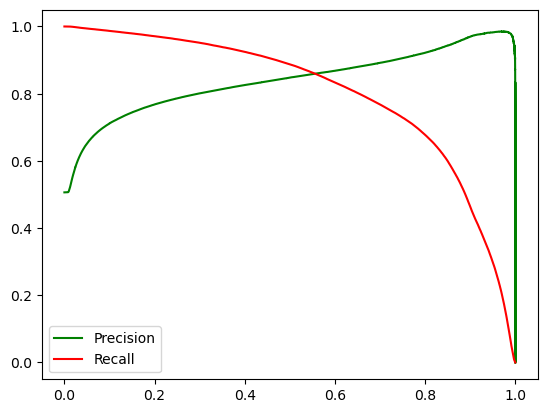

In [41]:
y_score = y_probabilities[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, y_score)
plt.plot(thresholds, precision[:-1], label='Precision', color='green')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.legend(loc='best')
plt.plot()

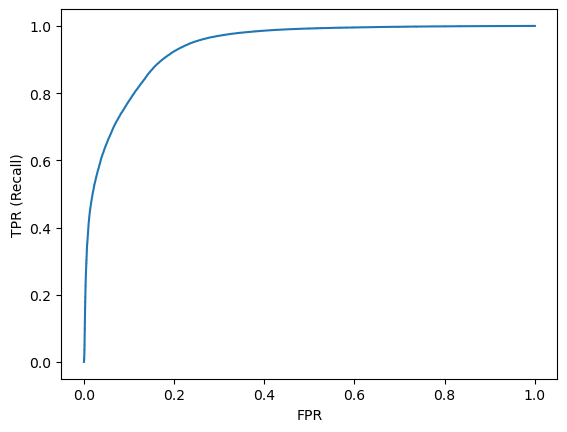

AUC: 0.94


In [42]:
# roc curve for top tagging 
fpr, tpr, thresholds = roc_curve(y_train, y_score)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.show()
print(f"AUC: {auc(fpr, tpr):.2f}")